In [1]:
import random
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint

import itertools

import scipy.integrate as spi
from scipy.integrate import quad
from scipy.special import erf,erfc
#import cvxpy as cp

from sympy import symbols, solve
from scipy.optimize import fsolve, root
from numpy.polynomial import polynomial as P

plt.rc('text',usetex=True)
plt.rc('font',family='serif')

In [2]:
#FOR 3 HORSES

def optWsigma(r,p,a):
    
    def J(b,a=a,r=r,p=p):
        log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
        log2=((np.log(b[0]/r[0]))**2,(np.log(b[1]/r[1]))**2,(np.log(b[2]/r[2]))**2)
        return -a*np.dot(p,log)+(1-a)*np.sqrt((np.dot(p,log2)-(np.dot(p,log))**2))
              
    def constraint(b):
        return np.sum(b)-1
    
    # Define the bounds as before
    bounds = [(0, 1), (0, 1), (0, 1)]


    # Define the equality constraint dictionary
    constraint_dict_eq = {'type': 'eq', 'fun': constraint}
    
    
    # Minimize the negative of the objective function
    res = minimize(J, [1/3, 1/3, 1/3], bounds=bounds, constraints=constraint_dict_eq)
    #print(res.x)

    # The maximum value of the original function is the negative of the minimum value found above
    max_value = -res.fun
    
    return res.x


In [3]:
def W_sigma(r,p,filename):
    par=np.linspace(0,1,100)
    W=[]
    sigma=[]
    Wnonopt=[]
    sigmanonopt=[]
    for a in par:
        b0,b1,b2=optWsigma(r,p,a)
        log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
        log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
        W.append(np.dot(p,log))
        sigma.append(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
        
        if a==1:
            kellyw=np.dot(p,log)
            kellys=np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2)
            
    #print(W)    
    for i in range(1000):
        b0=random.uniform(0.1, 1)
        b1=random.uniform(0.1,b0)
        b2=1-b1-b0
        if b2!=0:
            log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
            log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
            Wnonopt.append(np.dot(p,log))
            sigmanonopt.append(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
    Wnonopt=np.array(Wnonopt)
    sigmanonopt=np.array(sigmanonopt)
    #print(Wnonopt)
        
    plt.scatter(Wnonopt,sigmanonopt)
    plt.plot(W,sigma,'r',linewidth=3)
    plt.scatter([kellyw],[kellys],color='yellow',s=150)
    plt.scatter([0],[0],color='green',s=300)
    plt.xlabel('Average Growth Rate')
    plt.xlim(-0.01,1)
    plt.ylabel('Volatility')
    plt.ylim(-0.01,1.25)
    plt.savefig(filename)
    #plt.show()
    return W,sigma

In [4]:
#Defining the survival probability

def S2(t,B,x0,u,var):
    return 0.5*(1-erf((B-x0-u*t)/(np.sqrt(var*2*t))))-np.exp(-(2*u*(x0-B))/(var))*0.5*(1+erf((B-x0+u*t)/(np.sqrt(var*2*t))))
def S1(t,B,x0,u,var): #just another way to write it
    return 0.5*erfc((B-x0-u*t)/(np.sqrt(var*2*t)))-0.5*np.exp(-(2*u*(x0-B))/(var))*erfc((x0-B-u*t)/(np.sqrt(var*2*t)))

In [5]:
def maxim(r,p,beta,alpha):
    
    def Delta(b,r=r,p=p):
        log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
        return -np.dot(p,log)

    lamb=np.log(beta)/np.log(alpha)
    
    def constraint1(b,r=r,p=p,lamb=lamb):
        return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1
    
    def constraint2(b):
        return np.sum(b)-1
    
    nonlinear_constraint = NonlinearConstraint(constraint1, lb=float('-inf'), ub=0)
    
    # Define the bounds as before
    bounds = [(0, 1), (0, 1), (0, 1)]

    #constraint_dict_ineq = {'type': 'ineq', 'fun': constraint1}

    # Define the equality constraint dictionary
    constraint_dict_eq = {'type': 'eq', 'fun': constraint2}
    
    
    # Minimize the negative of the objective function
    res = minimize(Delta, [1/3, 1/3, 1/3], bounds=bounds, constraints=[nonlinear_constraint, constraint_dict_eq])
    #print(res.x)
    
    log=(np.log(res.x[0]/r[0]),np.log(res.x[1]/r[1]),np.log(res.x[2]/r[2]))
    log2=((np.log(res.x[0]/r[0]))**2,(np.log(res.x[1]/r[1]))**2,(np.log(res.x[2]/r[2]))**2)
    sigma=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
    # The maximum value of the original function is the negative of the minimum value found above
    max_value = -res.fun
    
    return max_value,sigma

In [6]:
def E_Pext(r,p,alpha):
    
    r=np.array(r)
    p=np.array(p)
    betas=np.linspace(0.0001,1,100)
    wealth=[]
    sigma=[]
    
    for beta in betas:
        optwealth,sigmax=maxim(r,p,beta,alpha)
        wealth.append(optwealth)
        sigma.append(sigmax)
    #print(wealth)
    #print(wealth[-1])
        if beta==1:
            kw,ks=maxim(r,p,beta,alpha)
            
    plt.plot(wealth,sigma,'r',label='Pareto front built from Boyd s aproach')

    #plt.xlabel('<W>')
    plt.xlabel(r'$\langle W \rangle$',fontsize=16)
    #plt.xlim(0,0.20)
    plt.ylabel('Volatility',fontsize=16)
    #plt.ylim(0,0.0001)
    plt.legend()
    plt.savefig('Fig1.pdf')
    plt.show()
        
    return wealth,sigma,betas,ks,kw

In [7]:
#p=(0.1,0.2,0.7)
#r=(0.7,0.1,0.2)
#E_Pext(r,p,0.7)

In [8]:
#COMPARING THE VOLATILITY AS RISK WRT EXTINCTION AS RISK FOR THE GRAPH W-P_ext

/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/3769706060.py:6: RuntimeWarning: divide by zero encountered in log
  log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/3769706060.py:7: RuntimeWarning: divide by zero encountered in log
  log2=((np.log(b[0]/r[0]))**2,(np.log(b[1]/r[1]))**2,(np.log(b[2]/r[2]))**2)
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/3769706060.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  return -a*np.dot(p,log)+(1-a)*np.sqrt((np.dot(p,log2)-(np.dot(p,log))**2))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/3769706060.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  return -a*np.dot(p,log)+(1-a)*np.sqrt((np.dot(p,log2)-(np.dot(p,log))**2))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/2581029265.py:24: RuntimeWarning: invalid value encountered in log
  log=(np.log(b0/r[0]),n

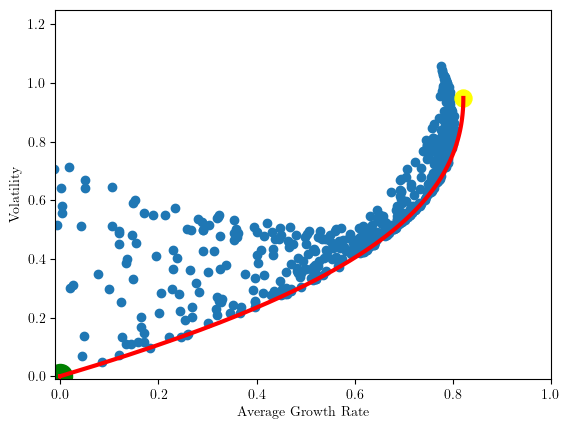

In [9]:
p=(0.1,0.2,0.7)
r=(0.7,0.1,0.2)
W,sigma=W_sigma(r,p,'3horses.pdf')

/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/1715920252.py:4: RuntimeWarning: overflow encountered in exp
  return 0.5*(1-erf((B-x0-u*t)/(np.sqrt(var*2*t))))-np.exp(-(2*u*(x0-B))/(var))*0.5*(1+erf((B-x0+u*t)/(np.sqrt(var*2*t))))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/1715920252.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  return 0.5*(1-erf((B-x0-u*t)/(np.sqrt(var*2*t))))-np.exp(-(2*u*(x0-B))/(var))*0.5*(1+erf((B-x0+u*t)/(np.sqrt(var*2*t))))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/2503227586.py:4: RuntimeWarning: divide by zero encountered in log
  log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_68756/2503227586.py:10: RuntimeWarning: divide by zero encountered in scalar power
  return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1


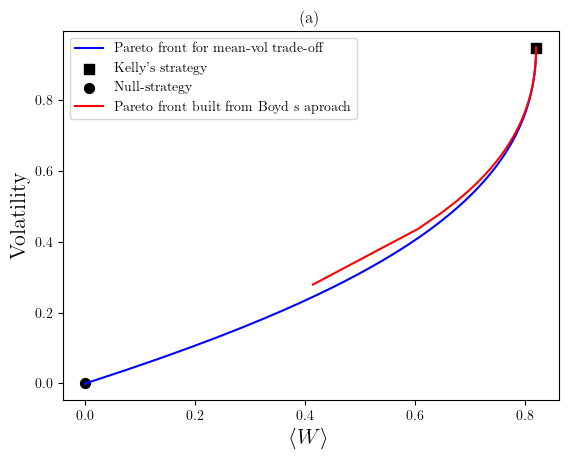

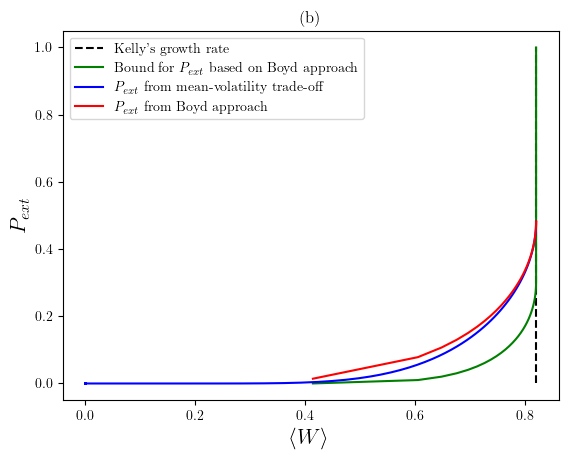

In [11]:
p=(0.1,0.2,0.7)
r=(0.7,0.1,0.2)
x0=1
t=100
alpha=0.3      #for an alpha of 0.9 to mimic the result one needs x0-B= 0.06 so B= 0.94
                    #for an aplha of 0.78 to mimic the result one needs x0-B= 0.13 so B= 0.87
                     #for an alpha of 0.5 to mimic one needs x0-B= 0.38 so B= 0.62
             #for an alpha of 0.3 to mimic one need x0-B= 0.66 so B= 0.34
                     #for an alpha of 0.1 to mimic one needs x0-B almost 1 so B=0
    
B=0.6 #0.87

kellyw=np.max(W)
kellys=np.max(sigma)

P_ext=np.ones(len(W))
for i in range(len(W)):
    u=W[i]
    var=(sigma[i])**2
    P_ext[i]=1-S2(t,B,x0,u,var)

plt.plot(W,sigma,'b',label='Pareto front for mean-vol trade-off')
plt.scatter([kellyw],[kellys],color='black',s=50,marker='s',label="Kelly's strategy")
plt.scatter([0],[0],color='black',s=50,label='Null-strategy')
plt.xlabel(r'$\langle W \rangle$',fontsize=16)
plt.ylabel('$P_{ext}$',fontsize=16)
plt.title('(a)')
plt.legend()


W1,sigma1,betas,ks,kw=E_Pext(r,p,alpha)

line,=plt.plot(kw*np.ones(len(betas)),betas,c='g', label="Kelly's growth rate",linestyle='dashed')
line.set_color('black')
plt.plot(W1,betas,'g',label='Bound for $P_{ext}$ based on Boyd approach')

plt.xlabel(r'$\langle W \rangle$',fontsize=16)
plt.ylabel('$P_{ext}$',fontsize=16)
plt.legend()

#B=round(B,2)
P_ext1=np.ones(len(W1))
for i in range(len(W1)):
    u=W1[i]
    var=(sigma1[i])**2
    P_ext1[i]=1-S2(t,B,x0,u,var)

plt.plot(W,P_ext,'b',label='$P_{ext}$ from mean-volatility trade-off')
plt.plot(W1,P_ext1,'r',label='$P_{ext}$ from Boyd approach')
plt.title('(b)')
plt.legend()
plt.savefig('Fig2.pdf')
plt.show()


#plt.plot(sigma1,betas,color='r',label='Pext-volatility relation for mean-vol trade-off')

#plt.savefig('Ps1.pdf')

#for i in range(len(W)):
#    u=W[i]
#    var=(sigma[i])**2
#    P_ext[i]=1-S2(t,B,x0,u,var)
    
#plt.plot(sigma1,Pext,color='b',label='Pext-volatility relation for mean-vol trade-off')

#plt.plot(sigma,P_ext,color='g',label='Pext-volatility relation for mean-extinction trade-off')
#line,=plt.plot(ks*np.ones(len(betas)),betas,c='g', label="Kelly's σw",linestyle='dashed')
#line.set_color('black')
#plt.title('(c)')
#plt.xlabel('σw ')
#plt.xlim(0,0.20)
#plt.ylabel('Pext')
#plt.legend()
#plt.savefig('Ps.pdf')
